# Analysis of the predictions 

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
acc_array = pd.read_csv('/home/aurelien/Desktop/FCN_bathy/data_CNN/Data_processed/Accuracy_test_set.csv')

## Performances depending on bathymetric surveys

In [4]:
acc_array.groupby('bathy')[['rmse', 'mae', 'pnsr', 'ssim', 'ms_ssim', 'std']].mean()

,rmse,mae,pnsr,ssim,ms_ssim,std
bathy,,,,,,
2017-03-27,0.593759,0.502837,21.046811,0.725402,0.878822,7.989835e-08
2018-01-31,0.485091,0.401813,22.824793,0.790319,0.900209,8.377986e-08
2021-03-03,0.327318,0.255109,26.588062,0.895886,0.939711,8.849807e-08
2021-06-21,0.300131,0.241908,25.877966,0.837722,0.916743,8.641036e-08


Text(0, 0.5, 'RMSE')

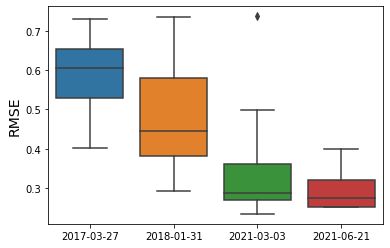

In [23]:
boxplot = sns.boxplot(y='rmse', x='bathy', data = acc_array)
boxplot.set_xlabel("", fontsize=14)
boxplot.set_ylabel("RMSE", fontsize=14)

We clearly see that the performances are worse when we try to predict rip structures (2017-03-27 and 2018-01-31)

## Do the environmental conditions differ ? 

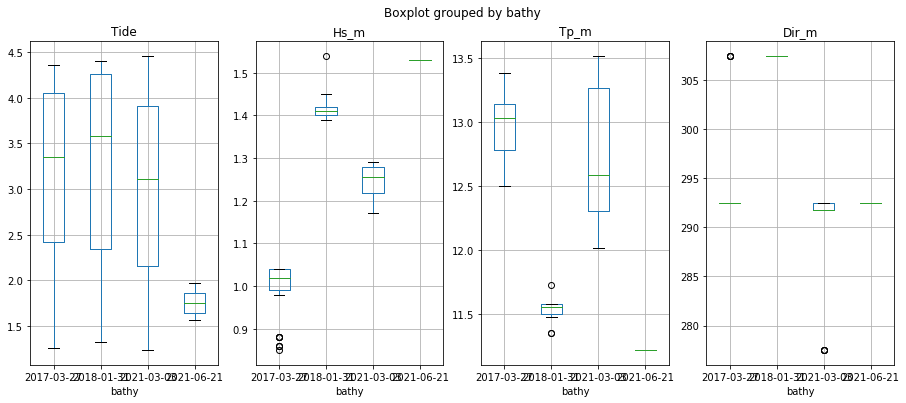

In [5]:
var_cond = ['Tide', 'Hs_m', 'Tp_m', 'Dir_m']
fig, axs = plt.subplots(1,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i, var in  enumerate(var_cond):
     acc_array.boxplot(var, 'bathy', ax = axs[i])


## Relationships between performance and environmental conditions

### For all the surveys

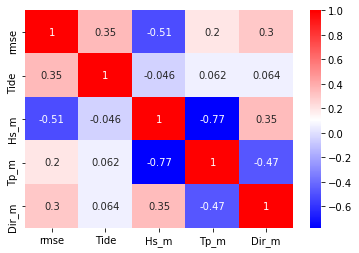

In [7]:
sns.heatmap(acc_array[['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

### For surveys with rip current

#### 2017-03-27

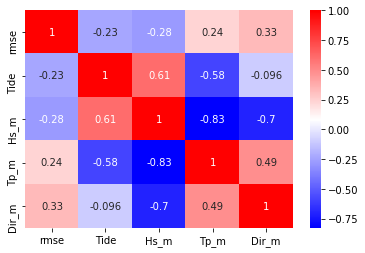

In [8]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2017-03-27'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

#### 2018-01-31

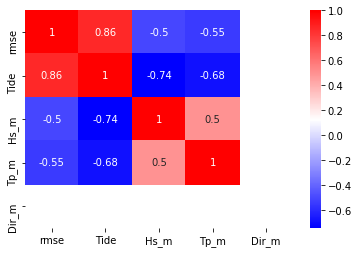

In [9]:
sns.heatmap(acc_array[acc_array['bathy'].isin(['2018-01-31'])][['rmse', 'Tide', 'Hs_m', 'Tp_m', 'Dir_m']].corr(), annot=True, cmap='bwr')

### Relationship with tide

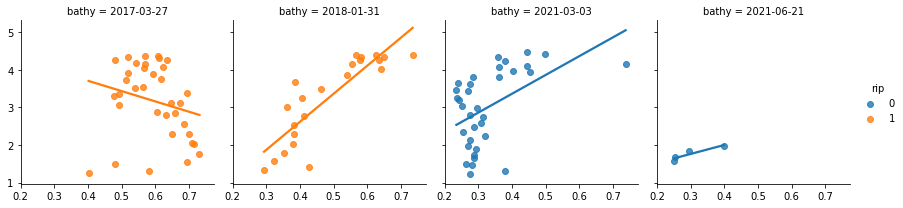

In [25]:
g = sns.FacetGrid(acc_array, col='bathy', hue="rip")
g.map_dataframe(sns.regplot, y='Tide', x='rmse', ci=None)
g.add_legend()

### Relationship with tide and wave

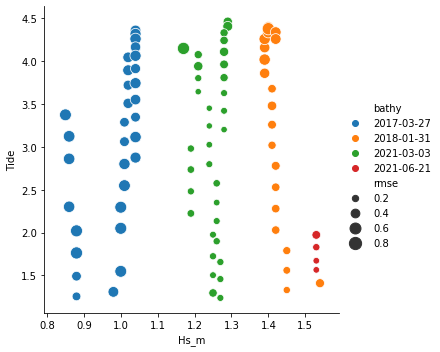

In [55]:
sns.relplot( y='Tide', x='Hs_m', hue="bathy", size = "rmse", sizes=(40, 150), data= acc_array)

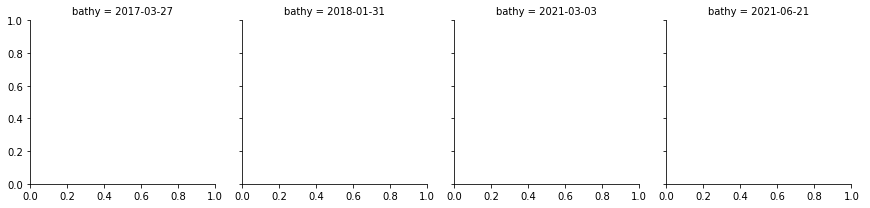

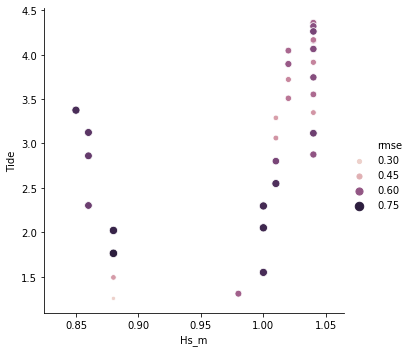

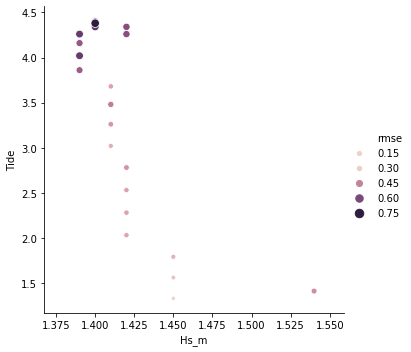

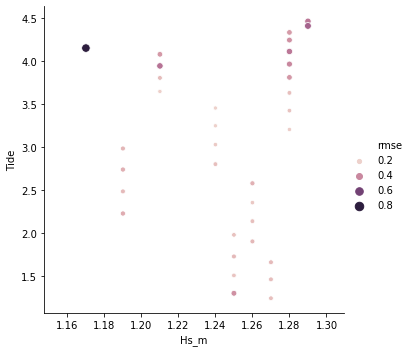

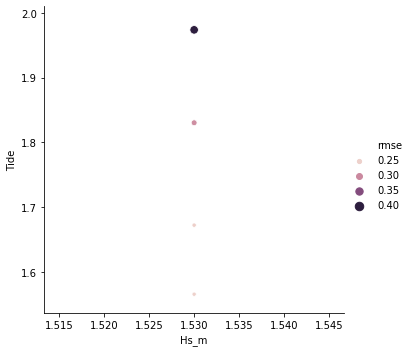

In [41]:
g = sns.FacetGrid(acc_array, col='bathy')
g.map_dataframe(sns.relplot, y='Tide', x='Hs_m', hue="rmse", size = "rmse")
g.add_legend()

### Relationship with Accuracy (rmse < 0.4) and environmental conditions
#### For all bathy

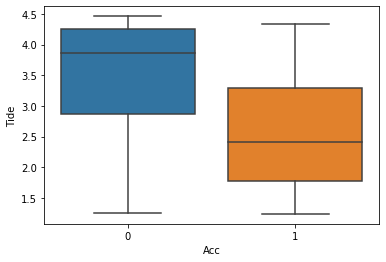

In [99]:
acc_array['Acc'] = 0
acc_array.loc[acc_array['rmse'] < 0.4, 'Acc'] = 1
acc_array['Acc'].value_counts()
sns.boxplot(y = 'Tide', x = 'Acc', data = acc_array)

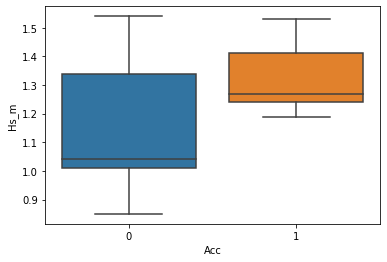

In [100]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = acc_array)

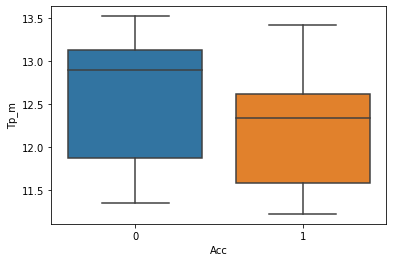

In [101]:
sns.boxplot(y = 'Tp_m', x = 'Acc', data = acc_array)

#### For bathy with rip

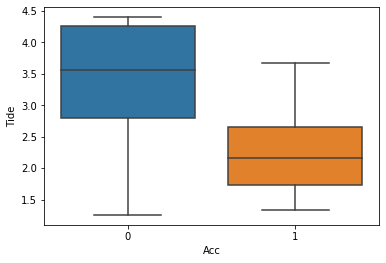

In [104]:
rip_bathy = acc_array[acc_array['rip'] == 1]
sns.boxplot(y = 'Tide', x = 'Acc', data = rip_bathy)

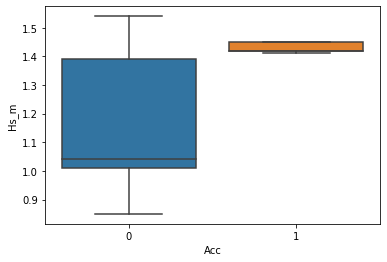

In [105]:
sns.boxplot(y = 'Hs_m', x = 'Acc', data = rip_bathy)

## Performances chosen vs all conditions 

In [111]:
acc_array[['rmse', 'mae', 'pnsr', 'ssim', 'ms_ssim', 'std']].mean()

rmse       4.608728e-01
mae        3.797947e-01
pnsr       2.364516e+01
ssim       8.061799e-01
ms_ssim    9.071636e-01
std        8.414921e-08
dtype: float64

In [121]:
sub_select = acc_array[(acc_array['Tide'] < 3) & (acc_array['Hs_m'] > 1.1)]
sub_select[['rmse', 'mae', 'pnsr', 'ssim', 'ms_ssim', 'std']].mean()

rmse       3.147642e-01
mae        2.485124e-01
pnsr       2.645175e+01
ssim       8.761657e-01
ms_ssim    9.324454e-01
std        8.691557e-08
dtype: float64

In [122]:
sub_select.shape

(28, 15)